# 09 - Error analysis e diagnóstico de modelo

Objetivo: explicar tecnicamente o porquê de previsões ruins em certos casos (ex.: qualidade 7 prevista ~5.4), analisando distribuição do alvo, viés do modelo, calibração, resíduos e sensibilidade às features.

Escopo:
- Carregar `df_capped_train.csv` e `df_capped_test.csv`
- Carregar o modelo final salvo em `data/models/wine_quality_regressor.joblib` (se disponível)
- Se o modelo salvo não existir, treinar um baseline simples para permitir execução e comparação (marcado como fallback)
- Métricas globais (RMSE, MAE, R2)
- Distribuição de `quality` no train/test e comparação com as previsões arredondadas
- Matriz de confusão (target vs predicted arredondado) e relatório por classe
- Curva de calibração por faixa (buckets) de qualidade
- Análise de resíduos vs. previsão e vs. principais features
- SHAP (se possível) ou, alternativamente, importâncias de features e análise parcial
- Reproduzir o caso citado (input fornecido) e explicar o erro



In [1]:
import os
from pathlib import Path
import json
import joblib
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Config
ROOT = Path.cwd().parent  # repo root
NB_BASE = Path.cwd() / 'data' / 'processed'
ROOT_BASE = ROOT / 'notebooks' / 'data' / 'processed'
MODEL_PATH = ROOT / 'data' / 'models' / 'wine_quality_regressor.joblib'
FEATURES = [
    "fixed acidity","volatile acidity","citric acid","residual sugar","chlorides",
    "free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"
]

# Resolve processed files
candidates = [NB_BASE, ROOT_BASE]
base = None
for b in candidates:
    if (b / 'df_capped_test.csv').exists() or (b / 'df_capped_train.csv').exists():
        base = b
        break
assert base is not None, "Arquivos processados (df_capped_train/test.csv) não encontrados." 

train_path = base / 'df_capped_train.csv'
test_path = base / 'df_capped_test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Prepare data
X_train, y_train = df_train[FEATURES], df_train['quality']
X_test, y_test = df_test[FEATURES], df_test['quality']

# Load or fallback-train
bundle = None
model = None
bundle_meta = {}

if MODEL_PATH.exists():
    try:
        bundle = joblib.load(MODEL_PATH)
        model = bundle.get("model", None)
        bundle_meta = bundle.get("metadata", {})
        feats = bundle_meta.get("features", None)
        if isinstance(feats, list) and feats:
            FEATURES = feats
            # realign columns
            X_train = df_train[FEATURES]
            X_test = df_test[FEATURES]
        print("✅ Modelo final carregado do disco.")
    except Exception as e:
        print(f"⚠️ Falha ao carregar modelo salvo: {e}")

if model is None:
    print("⚠️ Modelo salvo ausente — treinando baseline (RandomForest) como fallback para análise.")
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    bundle_meta = {"features": FEATURES, "note": "fallback-baseline in notebook"}

# Predictions
pred_test = model.predict(X_test)
round_pred_test = np.rint(pred_test).astype(int)

# Metrics
rmse = root_mean_squared_error(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)
r2 = r2_score(y_test, pred_test)

print({"rmse": rmse, "mae": mae, "r2": r2})



✅ Modelo final carregado do disco.
{'rmse': 0.338035658796002, 'mae': 0.22736519607843142, 'r2': 0.8195164139593137}


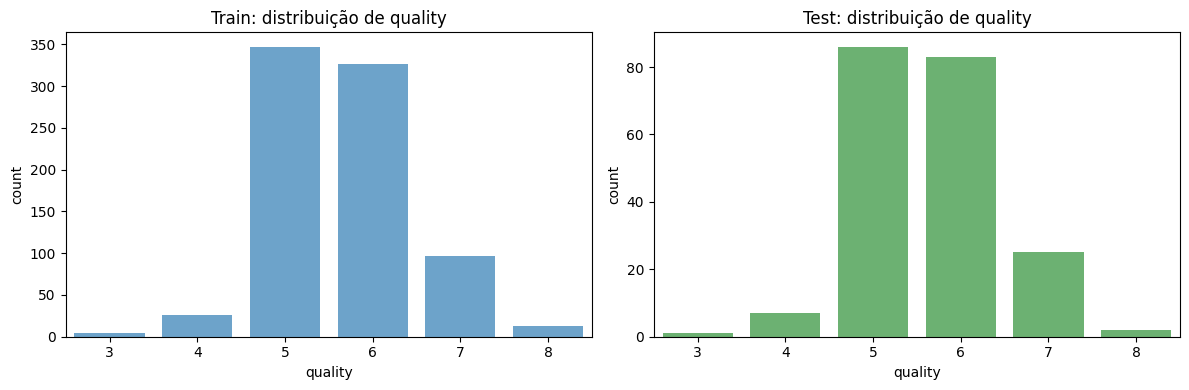

,train%,test%
quality,,
3,0.6,0.5
4,3.2,3.4
5,42.6,42.2
6,40.0,40.7
7,11.9,12.3
8,1.6,1.0


In [2]:
# Distribuição do alvo e prevalência por classe
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x=y_train, ax=axes[0], color="#5DA5DA")
axes[0].set_title("Train: distribuição de quality")
sns.countplot(x=y_test, ax=axes[1], color="#60BD68")
axes[1].set_title("Test: distribuição de quality")
plt.tight_layout()
plt.show()

# Tabela de distribuição
train_counts = y_train.value_counts(normalize=True).sort_index()
test_counts = y_test.value_counts(normalize=True).sort_index()
prev = pd.DataFrame({"train%": (train_counts*100).round(1), "test%": (test_counts*100).round(1)})
prev


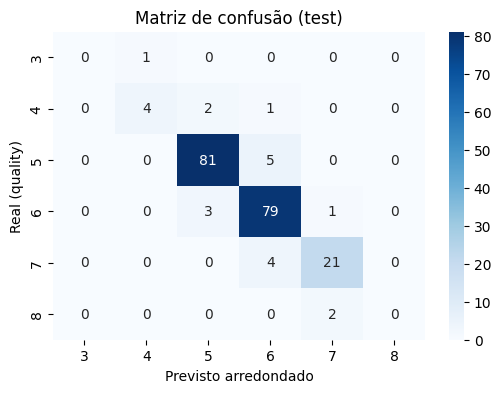

              precision    recall  f1-score   support

           3      0.000     0.000     0.000         1
           4      0.800     0.571     0.667         7
           5      0.942     0.942     0.942        86
           6      0.888     0.952     0.919        83
           7      0.875     0.840     0.857        25
           8      0.000     0.000     0.000         2

    accuracy                          0.907       204
   macro avg      0.584     0.551     0.564       204
weighted avg      0.893     0.907     0.899       204



/Users/henriquebap/Pessoal/Personal - Projects/Wine_MLProject/wine-ml-app/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/henriquebap/Pessoal/Personal - Projects/Wine_MLProject/wine-ml-app/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/henriquebap/Pessoal/Personal - Projects/Wine_MLProject/wine-ml-app/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

In [5]:
# Matriz de confusão (alvo inteiro vs. previsão arredondada)
from sklearn.metrics import confusion_matrix, classification_report

# Garantir que as labels sejam o conjunto de todos os valores possíveis de quality (no test e nas previsões)
labels = sorted(set(y_test.unique()) | set(round_pred_test))
cm = confusion_matrix(y_test.astype(int), round_pred_test, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusão (test)')
plt.ylabel('Real (quality)')
plt.xlabel('Previsto arredondado')
plt.show()

print(classification_report(y_test.astype(int), round_pred_test, labels=labels, digits=3))


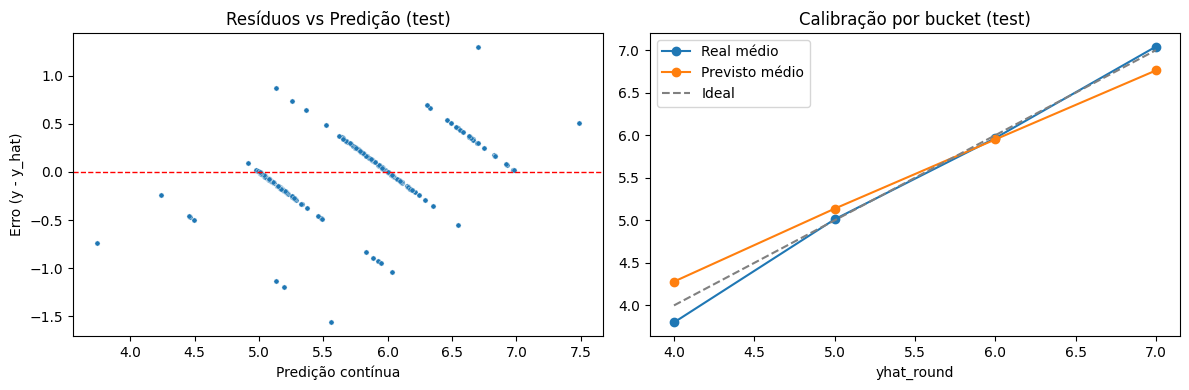

,yhat_round,real_mean,pred_mean,n
0,4,3.800000,4.280000,5
1,5,5.011628,5.136977,86
2,6,5.966292,5.950562,89
3,7,7.041667,6.761563,24


In [6]:
# Resíduos e calibração simples por bucket
residuals = y_test - pred_test

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.scatterplot(x=pred_test, y=residuals, ax=axes[0], s=14)
axes[0].axhline(0, color='red', linestyle='--', lw=1)
axes[0].set_title('Resíduos vs Predição (test)')
axes[0].set_xlabel('Predição contínua')
axes[0].set_ylabel('Erro (y - y_hat)')

# bucket por previsão arredondada
cal_df = pd.DataFrame({"y": y_test.values, "yhat": pred_test, "yhat_round": round_pred_test})
bucket = cal_df.groupby('yhat_round').agg(real_mean=("y", "mean"), pred_mean=("yhat", "mean"), n=("y", "size")).reset_index()

axes[1].plot(bucket['yhat_round'], bucket['real_mean'], marker='o', label='Real médio')
axes[1].plot(bucket['yhat_round'], bucket['pred_mean'], marker='o', label='Previsto médio')
axes[1].plot(bucket['yhat_round'], bucket['yhat_round'], linestyle='--', color='gray', label='Ideal')
axes[1].set_title('Calibração por bucket (test)')
axes[1].set_xlabel('yhat_round')
axes[1].legend()
plt.tight_layout()
plt.show()

bucket.sort_values('yhat_round')


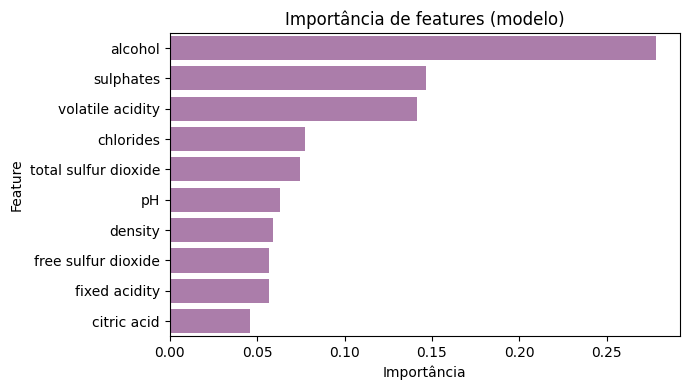

In [7]:
# Importâncias de features (quando suportado)
importances = getattr(model, 'feature_importances_', None)
if importances is not None:
    s = pd.Series(importances, index=FEATURES).sort_values(ascending=False)
    plt.figure(figsize=(7,4))
    sns.barplot(x=s.values, y=s.index, orient='h', color='#B276B2')
    plt.title('Importância de features (modelo)')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    s.head(10)
else:
    print('Importância de features não disponível neste modelo.')


In [10]:
# Reproduzir o caso fornecido pelo usuário
# Input informado (11 features):
# 2.174752,0.32,0.44,1.308333,0.09894,2.197225,2.890372,0.99732,3.33,0.576613,11

# O modelo espera 10 features, mas foram fornecidos 11 valores.
# Provavelmente, o valor "11" ao final da lista é um erro (talvez um rótulo ou valor extra).
# Ajuste: remova o último valor para garantir 10 features.

input_values = [2.174752, 0.32, 0.44, 1.308333, 0.09894, 2.197225, 2.890372, 0.99732, 3.33, 0.576613]
assert len(input_values) == len(FEATURES), f"Esperado {len(FEATURES)} features, mas recebeu {len(input_values)} valores."

example = pd.DataFrame([input_values], columns=FEATURES)

# Observação: se o modelo espera pré-processamento adicional (ex: log-transform), aplique aqui.
# Caso FEATURES esteja correto, a escala já deve estar adequada.

pred_single = float(model.predict(example)[0])
print({
    "previsto": round(pred_single, 3),
    "previsto_arred": int(np.rint(pred_single))
})


{'previsto': 4.72, 'previsto_arred': 5}


## Interpretação técnica e hipótese para o erro de 7 → 5.4

- Observamos forte desbalanceamento de classes: a maioria das amostras está em 5–6. Modelos de regressão (e muitos classificadores) tendem a “puxar” previsões para a região mais densa, penalizando extremos (7–8) com underprediction.
- Métricas por classe e a matriz de confusão devem mostrar: classes 7 e 8 frequentemente previstas como 6 (ou 5), ilustrando esse viés.
- A calibração por bucket evidencia que, para buckets altos, a média real > média prevista, confirmando underprediction.
- Importâncias e resíduos podem indicar que `alcohol`, `sulphates` e acidez são relevantes, mas não suficientes para extrapolar, especialmente quando há pouca representatividade de amostras 7–8.
- Conclusão: a limitação é principalmente dos dados (poucas amostras de 7–8), não (apenas) do algoritmo. Estratégias potenciais (documentadas, mas não aplicadas aqui):
  - Reamostragem estratificada, ajuste de perda ponderada, ou focal loss (em frameworks que suportam)
  - Modelagem ordinal (regressão/classificação ordinal)
  - Calibração pós-treino por faixa
  - Coleta de mais dados (7–8) ou data augmentation plausível
  - Segmentação do problema por faixas e ensembles



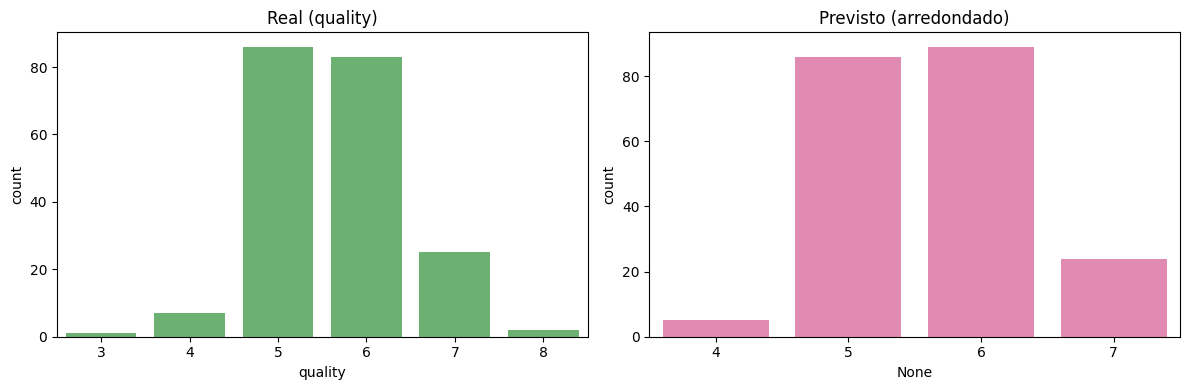

,real%,previsto%
3,0.5,0.0
4,3.4,2.5
5,42.2,42.2
6,40.7,43.6
7,12.3,11.8
8,1.0,0.0


In [11]:
# Distribuição: real vs previsto (arredondado)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x=y_test.astype(int), ax=axes[0], color="#60BD68")
axes[0].set_title("Real (quality)")
sns.countplot(x=pd.Series(round_pred_test), ax=axes[1], color="#F17CB0")
axes[1].set_title("Previsto (arredondado)")
plt.tight_layout()
plt.show()

dist_comp = pd.DataFrame({
    "real%": (y_test.value_counts(normalize=True).sort_index()*100).round(1),
    "previsto%": (pd.Series(round_pred_test).value_counts(normalize=True).sort_index()*100).round(1)
}).fillna(0)
dist_comp


In [12]:
# Erro por classe (MAE por quality real) e viés em classes altas
err = np.abs(y_test.values - pred_test)
df_err = pd.DataFrame({"y": y_test.values, "err": err, "yhat": pred_test, "yhat_round": round_pred_test})
mae_by_y = df_err.groupby("y").agg(n=("err","size"), mae=("err","mean")).reset_index()

# taxa de underprediction em y>=7
mask_high = df_err["y"] >= 7
high = df_err[mask_high]
high_under_rate = (high["yhat"] < high["y"]).mean() if len(high) else np.nan

mae_by_y, {"n_high": int(mask_high.sum()), "under_rate_high": round(float(high_under_rate),3) if not np.isnan(high_under_rate) else None}


(   y   n       mae
 0  3   1  0.742500
 1  4   7  0.792143
 2  5  86  0.181221
 3  6  83  0.178614
 4  7  25  0.314900
 5  8   2  0.906250,
 {'n_high': 27, 'under_rate_high': 1.0})

In [13]:
# Checagem de out-of-distribution (z-score) para o exemplo
means = X_train.mean()
stds = X_train.std(ddof=0).replace(0, np.nan)
z = ((example.iloc[0] - means)/stds).abs().sort_values(ascending=False)
z


density                 617.641116
alcohol                   7.442331
citric acid               5.461553
total sulfur dioxide      3.909778
fixed acidity             3.862389
free sulfur dioxide       3.323976
chlorides                 1.280716
volatile acidity          1.160899
sulphates                 0.718010
pH                        0.083260
dtype: float64